# Exploratory Data Analisys

The subjects are non-adult feature length movies from 1912–2012. The success parameters that are available are the movie's ratings (proxy for quality) and number of votes received (proxy for popularity). The confidence in a movie's rating increases as it receives more votes.

In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from pymongo import MongoClient
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
db = MongoClient().imdbws
df = pd.DataFrame(list(db.titles.find({'is_subject': True})))
# Numpy doesn't support MongoDB's Decimal128; let's transform it to Float.
to_decimal = lambda x: float(x.to_decimal()) if 'to_decimal' in dir(x) else x
df.averageRating = df.averageRating.apply(to_decimal)
#df.averageRating = df.averageRating.fillna(value=7)

## Histogram of Movies per Year

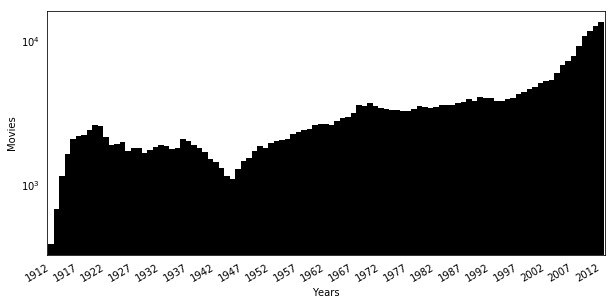

In [2]:
dfx = df.groupby(df["startYear"])._id.count()
ax = dfx.plot(kind="bar", figsize=(10,5), color='0.0', logy=True, width=1.0)
locator = ax.xaxis.get_major_locator()
locator.locs = locator.locs[::5]
formatter = ax.xaxis.get_major_formatter()
formatter.seq = formatter.seq[::5]
ax.get_figure().autofmt_xdate()
ax.set_ylabel('Movies')
ax.set_xlabel('Years')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

Each bar represents a 5-year period. Movies that received at least 5 votes are plotted separated from movies that received more than 5 votes.

Another view, now separating movies according to the number of received votes and binning 5-year periods:

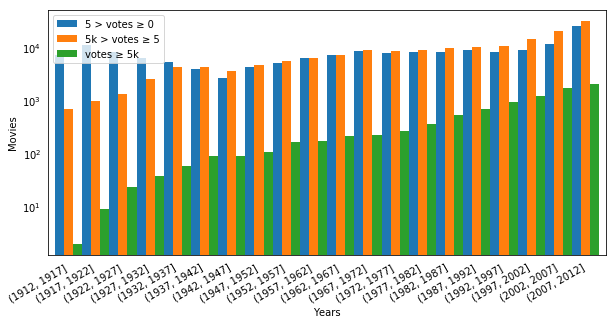

In [3]:
bins = np.arange(1912,2013, 5)
m1 = df.fillna(0).numVotes < 5
m2 = (df.numVotes >= 5) & (df.numVotes < 5000)
m3 = df.numVotes >= 5000
dfx = pd.DataFrame({
    '5 > votes ≥ 0': df[m1].groupby(pd.cut(df[m1].startYear, bins))._id.count(),
    '5k > votes ≥ 5': df[m2].groupby(pd.cut(df[m2].startYear, bins))._id.count(),
    'votes ≥ 5k': df[m3].groupby(pd.cut(df[m3].startYear, bins))._id.count()})
ax = dfx.plot(kind="bar", figsize=(10,5), logy=True, width=1)
ax.get_figure().autofmt_xdate()
ax.set_ylabel('Movies')
ax.set_xlabel('Years')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

## Ratings

A histogram of ratings (notice the y-log scale). Both the normalized and non-normalized ratings are shown.

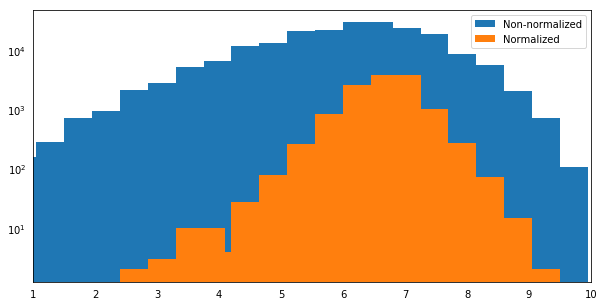

In [4]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[~df.averageRating.isnull()].averageRating, bins=20)
b_heights, b_bins = np.histogram(df[~df.nrating.isnull()].nrating, bins=a_bins)
ax.bar(a_bins[:-1], a_heights, label="Non-normalized")
ax.bar(b_bins[:-1], b_heights, label="Normalized")
ax.legend()
ax.set_xlim((1,10))
ax.set_yscale('log')
fig.set_size_inches(10,5)
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

### Number of Votes Histogram

Histogram of the logarithm of the number of votes. Notice the y-scale. The peak at the start corresponds to movies with the minimum number of votes.

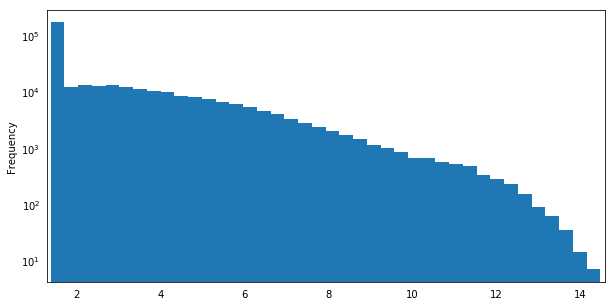

In [5]:
ax = df.log_votes.plot.hist(bins=40, figsize=(10,5))
ax.set_yscale('log')
ax.set_xlim((1.3,14.6))
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

### Normalized ratings per Number of Votes

Notice that normalized ratings were only defined for movies with log(votes) greater than 5,000. 

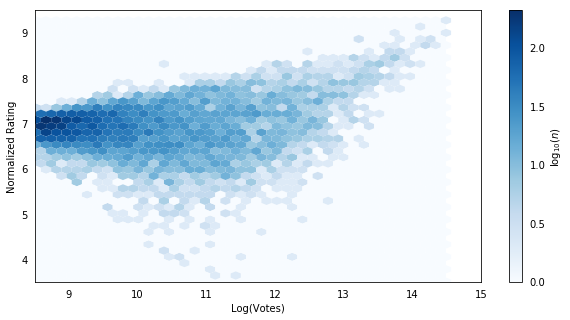

In [6]:
ax = df[~df.nrating.isnull()].plot.hexbin('log_votes', 'nrating', bins='log',
                    edgecolors='w', linewidths=(0.01,), cmap=plt.cm.Blues,
                    gridsize=40, ylim=(3.5,9.5), xlim=(8.5,15), sharex=False, figsize=(10,5))
ax.set_ylabel('Normalized Rating')
ax.set_xlabel('Log(Votes)')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')
cax = ax.get_figure().get_axes()[1] # Manually gets the colorbar axis.
cax.set_ylabel(r'$\log_{10}(n)$')
cax.tick_params(which='both', right='off')

### Distribution of Ratings by Decade

*TODO*: plot three boxplotes per decade side-by-side, each with data from success groups 'A', 'B' and 'C'.

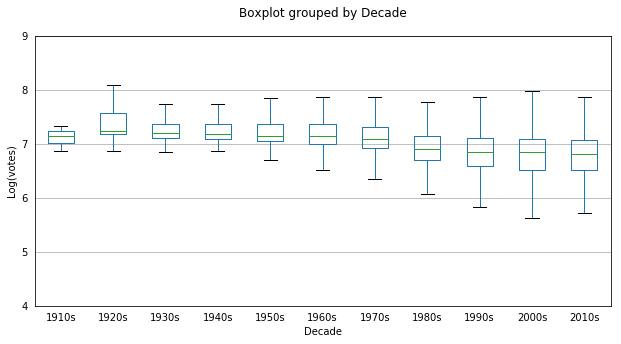

In [7]:
df['Decade'] = ((df['startYear'] // 10) * 10).astype('str') + 's'
ax = df[df.numVotes >= 5000].boxplot('nrating', by='Decade', showfliers=False, figsize=(10,5))
ax.set_ylim(4, 9)  # Movies are can be rated from 1 to 10.
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')
ax.set_ylabel('Log(votes)')
ax.set_title('')
ax.xaxis.grid(False)

### Distribution of Votes by Decade

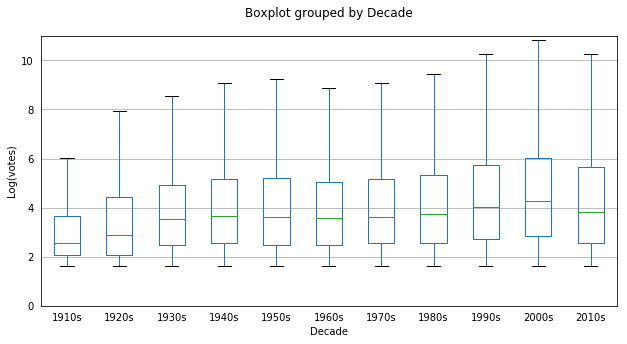

In [8]:
ax = df[df.numVotes >= 5].boxplot('log_votes', by='Decade', showfliers=False, figsize=(10,5))
ax.set_ylim(5)  # Movies don't have negative votes.
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')
ax.set_title("")
ax.set_ylim(0, 11)
ax.set_ylabel('Log(votes)')
ax.xaxis.grid(False)

How normalized ratings are distributed from groups of movies that received different number of votes.

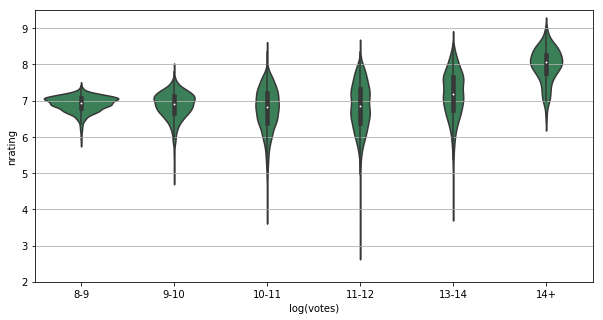

In [9]:
def name_bins(g):
    g['log(votes)'] = g.name
    return g
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
break_points = [8, 9, 10, 11, 12, 13, 14]
labels = ["8-9", "9-10", "10-11", "11-12", "13-14", "14+"]
dfx = df[~df.nrating.isnull()]
dfx = dfx.groupby(pd.cut(dfx.log_votes, break_points, labels=labels))
dfx = dfx.apply(name_bins)
ax = sns.violinplot(data=dfx, x="log(votes)", y="nrating", showmeans=False,
        showmedians=True, showfliers=False, order=labels, color="seagreen")
ax.set_ylim(2,9.5)
ax.yaxis.grid(True)